In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.table import Table
import emcee

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Text(0.5, 1.0, 'GJ 1243')

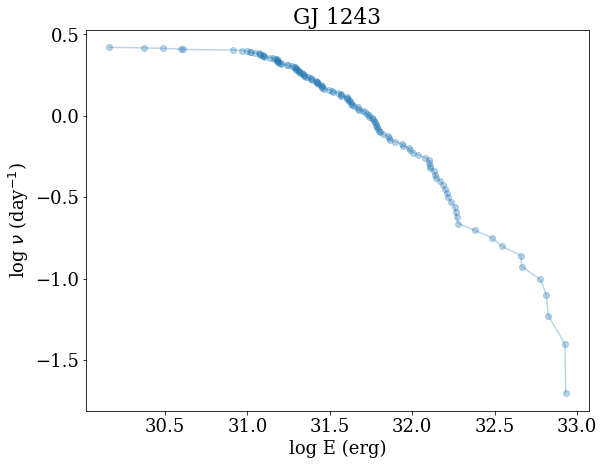

In [3]:
# TESS Luminosity
LUMIN = 31.061790465873248 # from "padova_lum" notebook
LUMIN_err = 0.039444830755122
# Kepler Luminosity
E_POINT = 30.67828435767249 # from "padova_lum" notebook
E_POINT_err = 0.04457627419541614
gj1243_dir = '../gj1243_10yrs/'

file = gj1243_dir + 'gj1243_tess.dat.fbeye'
colnames = ('Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x')

fbeye = pd.read_table(file, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row

file2 = gj1243_dir + 'gj1243_tess15.dat.fbeye'
fbeye2 = pd.read_table(file2, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row


file = gj1243_dir + 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'
tbl = Table.read(file, format='fits')
q = tbl['QUALITY'] == 0

file2 = gj1243_dir + 'tess2019226182529-s0015-0000000273589987-0151-s_lc.fits'
tbl2 = Table.read(file2, format='fits')
q2 = tbl2['QUALITY'] == 0
dt = np.nanmedian(np.diff(tbl['TIME'][q]))

ED = np.sort(np.concatenate((fbeye['Equiv_Dur'].values, fbeye2['Equiv_Dur'].values)))[::-1]
TOTDUR = dt * (sum(q) + sum(q2)) # days

ffd_x = np.log10(ED) + LUMIN
ffd_y = np.log10(np.arange(1, len(ED)+1) / TOTDUR)

plt.figure(figsize=(9,7))
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.3)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243')

In [4]:
# gj1243 : G-J = 11.55090 - 8.586
# YZCMi : G-J =  9.6807 - 6.58

print(11.55090 - 8.586, 9.6807 - 6.58)

2.9649 3.1007


(144, 19)


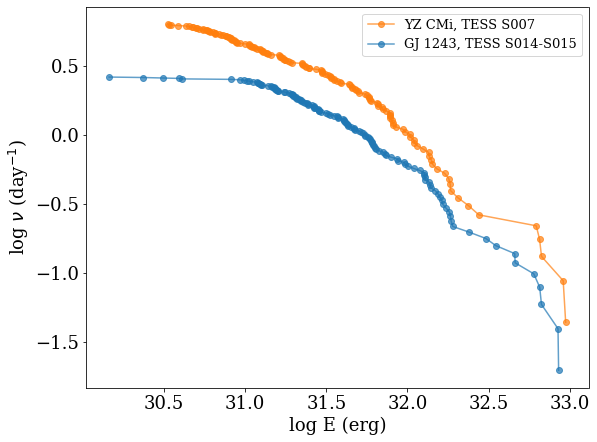

In [5]:
# LUMINY = 31.00192752813018 # from updated notebook (gj1243_10yrs/spectra/padova_lum)
# LUMINY_err = 0.22985294989763078

LUMINY  = 30.976368864140518 # from updated notebook (gj1243_10yrs/spectra/padova_lum)
LUMINY_err = 0.1148749988137026 # but using i-J instead of g-J b/c larger errors in g!

file = 'tess2019006130736-s0007-0000000266744225-0131-s_lc.fits.dat.fbeye'
fbeyeY = pd.read_table(file, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row

file = 'tess2019006130736-s0007-0000000266744225-0131-s_lc.fits'
tblY = Table.read(file, format='fits')
qY = tblY['QUALITY'] == 0
dt = np.nanmedian(np.diff(tblY['TIME'][qY]))

####
EDY = np.sort(fbeyeY['Equiv_Dur'].values)[::-1]
TOTDURY = dt * sum(qY) # days

ffd_xY = np.log10(EDY) + LUMINY
ffd_yY = np.log10(np.arange(1, len(EDY)+1) / TOTDURY)

plt.figure(figsize=(9,7))
plt.plot(ffd_xY, ffd_yY, '-o', color='C1', alpha=0.7, label='YZ CMi, TESS S007')
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.7, label='GJ 1243, TESS S014-S015')
plt.legend(fontsize=13)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
# plt.title('GJ 1243')

print(fbeyeY.shape)

2.772606015570289


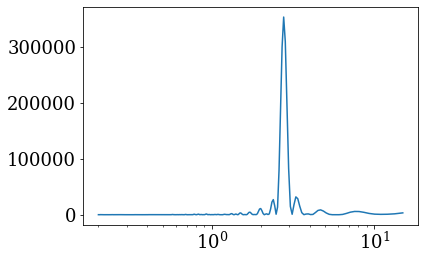

In [6]:
# plt.plot(tblY['TIME'][qY], tblY['PDCSAP_FLUX'][qY])
import exoplanet as xo

lnp = xo.lomb_scargle_estimator(tblY['TIME'][qY].data, tblY['PDCSAP_FLUX'][qY].data, min_period=0.2, max_period=15)

freq, pwr = lnp['periodogram']
plt.plot(1./freq, pwr)
plt.xscale('log')

print(lnp['peaks'][0]['period'])

In [7]:
import sys
sys.path
sys.path.append('/Users/james/python/FFD/')
from FFD import FFD, FlareKernel

#gj1243
ffd_x,ffd_ylog,ffd_xerr,ffd_yerrlog = FFD(np.concatenate((fbeye['Equiv_Dur'].values, 
                                    fbeye2['Equiv_Dur'].values)), TOTEXP=TOTDUR, Lum=LUMIN, 
                    dur=np.concatenate((fbeye['t_stop'].values-fbeye['t_start'].values, 
                                        fbeye2['t_stop'].values-fbeye2['t_start'].values)), 
                    fluxerr=np.nanmedian(tbl['PDCSAP_FLUX_ERR'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q])),logY=True)

ffd_x,ffd_y,ffd_xerr,ffd_yerr = FFD(np.concatenate((fbeye['Equiv_Dur'].values, 
                                    fbeye2['Equiv_Dur'].values)), TOTEXP=TOTDUR, Lum=LUMIN, 
                    dur=np.concatenate((fbeye['t_stop'].values-fbeye['t_start'].values, 
                                        fbeye2['t_stop'].values-fbeye2['t_start'].values)), 
                    fluxerr=np.nanmedian(tbl['PDCSAP_FLUX_ERR'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q])),logY=False)

#yzcmi
ffd_xY,ffd_yYlog,ffd_xerrY,ffd_yerrYlog = FFD(fbeyeY['Equiv_Dur'].values, TOTEXP=TOTDURY, Lum=LUMINY, 
                                        dur=fbeyeY['t_stop'].values-fbeyeY['t_start'].values, 
                fluxerr=np.nanmedian(tblY['PDCSAP_FLUX_ERR'][qY] / np.nanmedian(tblY['PDCSAP_FLUX'][qY])),logY=True)

ffd_xY,ffd_yY,ffd_xerrY,ffd_yerrY = FFD(fbeyeY['Equiv_Dur'].values, TOTEXP=TOTDURY, Lum=LUMINY, 
                                        dur=fbeyeY['t_stop'].values-fbeyeY['t_start'].values, 
                fluxerr=np.nanmedian(tblY['PDCSAP_FLUX_ERR'][qY] / np.nanmedian(tblY['PDCSAP_FLUX'][qY])),logY=False )


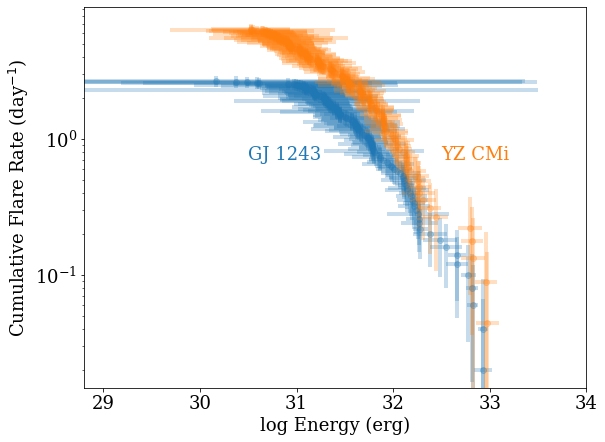

In [8]:
plt.figure(figsize=(9,7))

plt.errorbar(ffd_x, ffd_y, xerr=np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=4, marker='o')

plt.errorbar(ffd_xY, ffd_yY, xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=4, marker='o')


plt.yscale('log')

plt.xlabel('log Energy (erg)')
plt.ylabel(r'Cumulative Flare Rate (day$^{-1}$)')
# plt.title('GJ 1243 (M4, P$_{rot}$=0.59d)', fontsize=14)

# plt.text(31.5, 5, 'Kepler',color='k')
plt.text(30.5, 0.7,'GJ 1243', color='C0')
plt.text(32.5, 0.7,'YZ CMi', color='C1')
plt.xlim(28.8,34)

plt.savefig('YZCMI_vs_GJ1243.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## fitting the FFD
there's lots of ways to fit a FFD, perhaps none of the good

In [9]:
from scipy.odr import ODR, Model, Data, RealData

In [10]:
def f(B, x):
    if B[0] > 0:
        return np.inf
#     B[0] = -1 # fix slope? no
    return 10**(B[0]*x + B[1])

In [11]:
def quickfit(x,y,xe,ye):
    
    b00, b10 = -1., 30

    linear = Model(f)
    ok = np.where(np.isfinite(x) & np.isfinite(y) & np.isfinite(xe) & np.isfinite(ye))[0]
    mydata = RealData(x[ok], y[ok], sx=xe[ok], sy=ye[ok])
    myodr = ODR(mydata, linear, beta0=[b00, b10])
    myoutput = myodr.run()

    m, b = myoutput.beta[0], myoutput.beta[1]
    m_err, b_err = myoutput.sd_beta[0], myoutput.sd_beta[1]

    return m,b,m_err,b_err
    

-0.8674483631895066 27.474264859622792 0.015964901470203914 0.5073676360730303
-0.7203333324093111 23.047923747600557 0.01751789012303678 0.5521312832678663


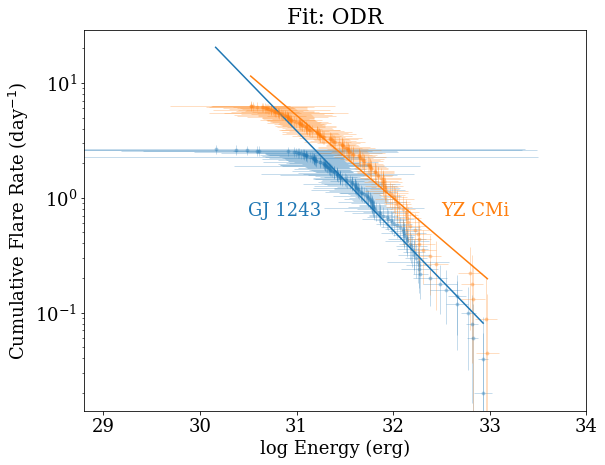

In [12]:
plt.figure(figsize=(9,7))

plt.errorbar(ffd_x, ffd_y, xerr=np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=1, marker='.')

plt.errorbar(ffd_xY, ffd_yY, xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=1, marker='.')

m,b,m_err,b_err = quickfit(ffd_x, ffd_y, 
                           np.sqrt(ffd_xerr**2+LUMIN_err**2), ffd_yerr)
mY,bY,m_errY,b_errY = quickfit(ffd_xY, ffd_yY, 
                               np.sqrt(ffd_xerrY**2+LUMINY_err**2), ffd_yerrY)

plt.plot(ffd_x, 10**(m*ffd_x + b))
plt.plot(ffd_xY, 10**(mY*ffd_xY + bY))

plt.yscale('log')

plt.xlabel('log Energy (erg)')
plt.ylabel(r'Cumulative Flare Rate (day$^{-1}$)')
# plt.title('GJ 1243 (M4, P$_{rot}$=0.59d)', fontsize=14)

# plt.text(31.5, 5, 'Kepler',color='k')
plt.text(30.5, 0.7,'GJ 1243', color='C0')
plt.text(32.5, 0.7,'YZ CMi', color='C1')
plt.xlim(28.8,34)

plt.title('Fit: ODR')
# plt.savefig('YZCMI_vs_GJ1243.png', dpi=150, bbox_inches='tight', pad_inches=0.25)


print(m,b,m_err,b_err)
print(mY,bY,m_errY,b_errY)

In [13]:
def therng(thething, rng=[15,50,84]):
    pcent = np.percentile(thething, rng)
    q = np.diff(pcent)
    return pcent[1], q[0], q[1]

In [14]:
def FFD_mcmc(ffd_x, ffd_y, ffd_xerr, ffd_yerr, Nmin=10, Nsteps=2000):
    
    def _lnProb(theta, x, y, xerr, yerr):
        m, b, xmin = theta
        model = 10**(m * x + b)
        xmodel = (np.log10(y) - b)/m
        xok = x > xmin
        
        # I hate that Python lets variables creep into scope like this, but OK!
        if (sum(xok) >= Nmin) and (-5 < m < -0) and (0 < b < 100) and ( 0 < xmin < np.max(x)):
            
            # my 1st attempt at reduced chi-sq, trying to approximate X and Y errors
#             chisq = (np.sum(((y[xok] -  model[xok])/yerr[xok] )** 2) + 
#                      np.sum(((x[xok] - xmodel[xok])/xerr[xok] )** 2)) / np.float(np.sum(xok))

            # my 2nd attempt, better i think
            chisq = np.sum(((y[xok] -  model[xok])/yerr[xok])** 2 * 
                           ((x[xok] - xmodel[xok])/xerr[xok])** 2) / np.float(np.sum(xok))

            BIC = chisq + np.size(theta) * np.log(len(x)+(np.float(len(x) - np.sum(xok))))
            return -0.5 * BIC
#             return -0.5 * chisq

        return -np.inf

    # initialization
    xok = (ffd_x >= np.mean(ffd_x))
    fit, cov = np.polyfit(ffd_x[xok], np.log10(ffd_y[xok]), 1, 
                     w=1./((ffd_yerr[xok]**2 + (-1 * ffd_xerr[xok])**2)), cov=True)

    pos = np.array([fit[0], fit[1], np.mean(ffd_x)]) + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _lnProb, 
                                    args=(ffd_x, ffd_y, ffd_xerr, ffd_yerr))
    
    sampler.run_mcmc(pos, Nsteps, progress=True);
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=int(Nsteps*0.1), thin=15, flat=True)
    
    return flat_samples

In [15]:
flat_samplesY = FFD_mcmc(ffd_xY, ffd_yY, ffd_xerrY, ffd_yerrY, Nsteps=1000)
# flat_samplesY = FFD_mcmc(ffd_xY, ffd_yY, 
#                          np.sqrt(ffd_xerrY**2+(LUMINY_err)**2), ffd_yerrY, Nsteps=1000)
print(np.median(flat_samplesY, axis=0))

100%|██████████| 1000/1000 [00:16<00:00, 59.34it/s]

[-1.12533612 35.98835128 31.62188547]


(-1.1253361222556748, 0.14448491774882743, 0.12489953491137018)
(35.98835127725461, 4.168236473403315, 4.461983537904217)
(31.621885466529342, 0.3143060333835095, 0.30370621569897693)


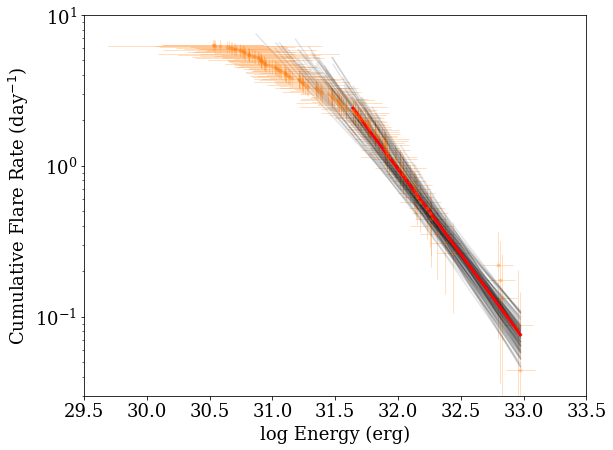

In [16]:
plt.figure(figsize=(9,7))
inds = np.random.randint(len(flat_samplesY), size=100)
for ind in inds:
    sample = flat_samplesY[ind]
    plt.plot([sample[2], max(ffd_xY)], 10**(sample[0]*np.array([sample[2], max(ffd_xY)]) + sample[1]),
             "k", alpha=0.1)
    
plt.errorbar(ffd_xY, ffd_yY, xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=1, marker='.')
plt.plot(ffd_xY[ffd_xY >= np.median(flat_samplesY[:,2])], 
         10**(np.median(flat_samplesY[:,0]) * ffd_xY[ffd_xY >= np.median(flat_samplesY[:,2])] + np.median(flat_samplesY[:,1])), 
         c='r', lw=3)

plt.yscale('log')

plt.xlim(29.5,33.5)
plt.ylim(3e-2, 1e1)
plt.xlabel('log Energy (erg)')
plt.ylabel(r'Cumulative Flare Rate (day$^{-1}$)')

print(therng(flat_samplesY[:,0]))
print(therng(flat_samplesY[:,1]))
print(therng(flat_samplesY[:,2]))

In [17]:
# flat_samples = FFD_mcmc(ffd_x, ffd_y, np.sqrt(ffd_xerr**2+LUMIN_err**2), ffd_yerr, Nsteps=1000)
flat_samples = FFD_mcmc(ffd_x, ffd_y, ffd_xerr, ffd_yerr, Nsteps=1000)
print(np.median(flat_samples, axis=0))

100%|██████████| 1000/1000 [00:15<00:00, 64.84it/s]

[-1.06910458 33.91402252 31.53648288]


(-1.069104583783106, 0.4999772052791116, 0.2292351508060303)
(33.914022519701874, 7.57882943283343, 15.417171259560078)
(31.536482884887118, 8.750809116266907, 0.598918577885815)


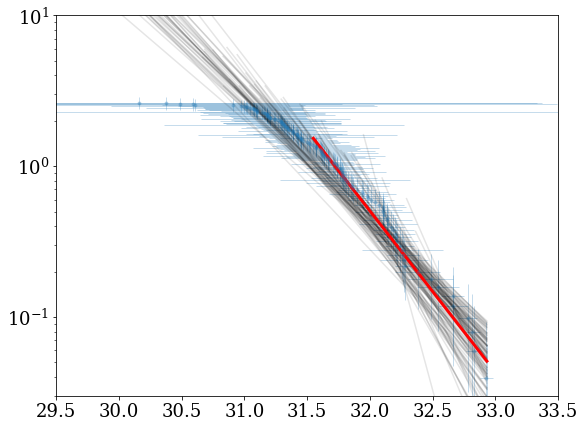

In [18]:
plt.figure(figsize=(9,7))

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot([sample[2], max(ffd_x)], 10**(sample[0]*np.array([sample[2], max(ffd_x)]) + sample[1]), "k", alpha=0.1)

    
plt.errorbar(ffd_x, ffd_y, xerr=np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=1, marker='.')
plt.plot(ffd_x[ffd_x >= np.median(flat_samples[:,2])], 
         10**(np.median(flat_samples[:,0]) * ffd_x[ffd_x >= np.median(flat_samples[:,2])] + np.median(flat_samples[:,1])), 
         c='r', lw=3)

plt.yscale('log')
plt.xlim(29.5,33.5)
plt.ylim(3e-2, 1e1)

print(therng(flat_samples[:,0]))
print(therng(flat_samples[:,1]))
print(therng(flat_samples[:,2]))

(0.03, 10.0)

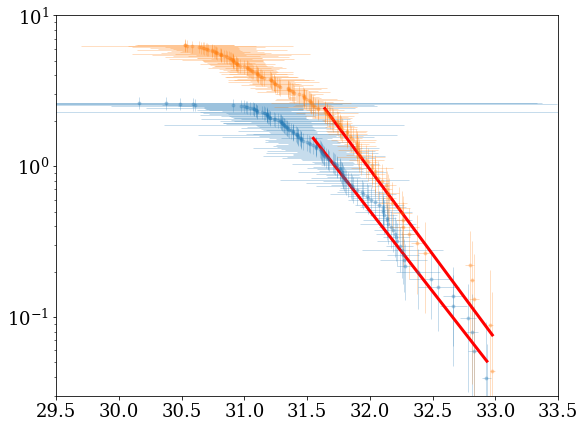

In [19]:
plt.figure(figsize=(9,7))
    
plt.errorbar(ffd_x, ffd_y, xerr=ffd_xerr,#np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=1, marker='.')
   
plt.errorbar(ffd_xY, ffd_yY, xerr=ffd_xerrY,#np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=1, marker='.')
plt.plot(ffd_x[ffd_x >= np.median(flat_samples[:,2])], 
         10**(np.median(flat_samples[:,0]) * ffd_x[ffd_x >= np.median(flat_samples[:,2])] + np.median(flat_samples[:,1])), 
         c='r', lw=3)

plt.plot(ffd_xY[ffd_xY >= np.median(flat_samplesY[:,2])], 
         10**(np.median(flat_samplesY[:,0]) * ffd_xY[ffd_xY >= np.median(flat_samplesY[:,2])] + np.median(flat_samplesY[:,1])), 
         c='r', lw=3)

plt.yscale('log')
plt.xlim(29.5,33.5)
plt.ylim(3e-2, 1e1)

In [20]:
def nrpt(x3, y3, m, b):
    ''' find the nearest point on a line '''
    # https://stackoverflow.com/a/47198877
    x1 = 0.
    x2 = x3
    y1 = x1*m + b
    y2 = x2*m + b
    
    dx, dy = x2-x1, y2-y1
    det = dx*dx + dy*dy
    a = (dy*(y3-y1) + dx*(x3-x1)) / det
    return x1+a*dx, y1+a*dy


[-1.25205717 39.87196878]
0.10663473708991006 0.027444575684357205


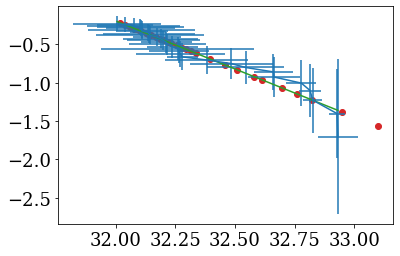

In [21]:
xok = (ffd_x >= 32)
fit = np.polyfit(ffd_x[xok], ffd_ylog[xok], 1)

print(fit)
# fit = [-1, -1]
plt.errorbar(ffd_x[xok], ffd_ylog[xok], xerr=ffd_xerr[xok], yerr=ffd_yerrlog[xok])
# plt.scatter(ffd_x, ffd_ylog, c='C1')
plt.plot(ffd_x[xok], np.polyval(fit, ffd_x[xok]), c='C2')

xnew, ynew = nrpt(ffd_x, ffd_ylog, *fit)
plt.scatter(xnew[xok], ynew[xok], c='C3')

normalchisq = np.sum( ((ffd_ylog[xok] - np.polyval(fit, ffd_x[xok]))/ffd_yerrlog[xok])**2 ) / np.float(np.sum(xok))

dist = np.sqrt((ffd_x[xok]-xnew[xok])**2 + (ffd_ylog[xok]-ynew[xok])**2)
errs = np.sqrt((ffd_xerr[xok])**2 + (ffd_yerrlog[xok])**2)
newchisq = np.sum( (dist/errs)**2 ) / np.float(np.sum(xok))

print(normalchisq, newchisq)

In [22]:
def _lnProb(theta, x, y, xerr, yerr):
    Nmin = 10
    m, b, xmin = theta
    xok = x > xmin

    # implement some strict "priors" here
    if ((sum(xok) >= Nmin) and (-2 < m < -0.5) and (20 < b < 40) and 
        (np.min(x) < xmin < np.max(x))):

        # orthogonal distance of points to the line
        xnew, ynew = nrpt(x, y, m, b)

        # the York2004 version of the chisq
#             chisq = np.sum((y[xok] - model[xok])**2 / 
#                            (yerr[xok]**2 + (m * xerr[xok])**2)) / np.float(np.sum(xok))

#             chisq = np.sum(((x[xok]-xnew[xok])/xerr[xok])**2 *
#                            ((y[xok]-ynew[xok])/yerr[xok])**2 ) / np.float(np.sum(xok))
        # orthog distance chisq 
        dist = np.sqrt((x[xok]-xnew[xok])**2 + (y[xok]-ynew[xok])**2)
        errs = np.sqrt((xerr[xok])**2 + (yerr[xok])**2)
        chisq = np.sum( (dist/errs)**2 ) / np.float(np.sum(xok))

        BIC = chisq + np.size(theta) * np.log(len(x)+(np.float(len(x) - np.sum(xok))))
        return -0.5 * BIC

    return -np.inf

In [23]:
def FFD_odr(ffd_x, ffd_y, ffd_xerr, ffd_yerr, Nsteps=2000):
    
    # initialization
    xok = (ffd_x >= np.mean(ffd_x))
    fit = np.polyfit(ffd_x[xok], ffd_y[xok], 1)

    pos = np.array([fit[0], fit[1], np.min(ffd_x)]) 
    pos = pos + 1e-4 * np.random.randn(2**5, pos.size)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _lnProb, 
                                    args=(ffd_x, ffd_y, ffd_xerr, ffd_yerr))
    
    sampler.run_mcmc(pos, Nsteps, progress=True);
    samples = sampler.get_chain()
    flat_samples = sampler.get_chain(discard=int(Nsteps*0.1), thin=15, flat=True)
    
    return flat_samples

In [ ]:
# Our errors seem too small (chisq << 0 near the best model)

# so this actually seems to work oddly well by down-weighting the errors. Huh.
fudge = 5.
flat_samplesY2 = FFD_odr(ffd_xY, ffd_yYlog, ffd_xerrY/fudge, ffd_yerrYlog/fudge,  Nsteps=1000)

 12%|█▎        | 125/1000 [00:02<00:19, 44.74it/s]

In [ ]:
plt.figure(figsize=(9,7))
inds = np.random.randint(len(flat_samplesY2), size=100)
for ind in inds:
    sample = flat_samplesY2[ind]
    plt.plot([sample[2], max(ffd_xY)], (sample[0]*np.array([sample[2], max(ffd_xY)]) + sample[1]),
             "k", alpha=0.1)
    
plt.errorbar(ffd_xY, ffd_yYlog, xerr=ffd_xerrY,#np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrYlog, 
             color='C1', alpha=0.25, linestyle='none', lw=1, marker='.')

plt.plot(ffd_xY[ffd_xY >= np.median(flat_samplesY2[:,2])], 
         (np.median(flat_samplesY2[:,0]) * ffd_xY[ffd_xY >= np.median(flat_samplesY2[:,2])] + 
          np.median(flat_samplesY2[:,1])), 
         c='r', lw=3)

plt.xlim(29.5,33.5)
plt.ylim(-2, 1)
plt.xlabel('log Energy (erg)')
plt.ylabel(r'log Cumulative Flare Rate (day$^{-1}$)')

print(therng(flat_samplesY2[:,0]))
print(therng(flat_samplesY2[:,1]))
print(therng(flat_samplesY2[:,2]))

In [ ]:
flat_samples2 = FFD_odr(ffd_x, ffd_ylog, ffd_xerr/fudge, ffd_yerrlog/fudge, Nsteps=1000)

In [ ]:
plt.figure(figsize=(9,7))
inds = np.random.randint(len(flat_samplesY2), size=100)
for ind in inds:
    sample = flat_samples2[ind]
    plt.plot([sample[2], max(ffd_x)], (sample[0]*np.array([sample[2], max(ffd_x)]) + sample[1]),
             "k", alpha=0.1)
    
plt.errorbar(ffd_x, ffd_ylog, xerr=ffd_xerr, 
             yerr=ffd_yerrlog, 
             color='C0', alpha=0.25, linestyle='none', lw=1, marker='.')

plt.plot(ffd_x[ffd_x >= np.median(flat_samples2[:,2])], 
         (np.median(flat_samples2[:,0]) * ffd_x[ffd_x >= np.median(flat_samples2[:,2])] + 
          np.median(flat_samples2[:,1])), 
         c='r', lw=3)

plt.xlim(29.5,33.5)
plt.ylim(-2, 1)
plt.xlabel('log Energy (erg)')
plt.ylabel(r'log Cumulative Flare Rate (day$^{-1}$)')

print(therng(flat_samples2[:,0]))
print(therng(flat_samples2[:,1]))
print(therng(flat_samples2[:,2]))